In [1]:
# Remove these two lines when converting to .py files later.
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time

import pandas as pd

import psycopg2
from sqlalchemy import create_engine

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

import numpy as np
from scipy import signal
from scipy.signal import detrend

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Create a SparkSession
spark = SparkSession \
    .builder \
    .appName("Data Stager") \
    .config("spark.driver.memory", '8g') \
    .config("spark.driver.maxResultSize", '2g') \
    .config("spark.jars", "postgresql_jars/postgresql-42.2.18.jar") \
    .getOrCreate()

spark.sparkContext.setLogLevel('ERROR')

print("Reading the CSV files..")
semg_df = spark.read.parquet("dataset_parquet_stage/", header=True, inferSchema=True)
semg_df.printSchema()
print("Completed reading the CSV files.")


23/09/05 23:11:16 WARN Utils: Your hostname, Sauravs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.16.2.136 instead (on interface en0)
23/09/05 23:11:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/09/05 23:11:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Reading the CSV files..


root
 |-- subject_id: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- semg_1: double (nullable = true)
 |-- semg_2: double (nullable = true)
 |-- semg_3: double (nullable = true)
 |-- semg_4: double (nullable = true)
 |-- semg_5: double (nullable = true)
 |-- sub_activity: double (nullable = true)
 |-- activity: double (nullable = true)
 |-- repetition_index: double (nullable = true)
 |-- trial_index: double (nullable = true)
 |-- manual_sub_activity: double (nullable = true)

Completed reading the CSV files.


In [4]:
window_spec = Window.partitionBy('subject_id', 'activity', 'trial_index').orderBy('index')
semg_df = semg_df.withColumn('index', F.row_number().over(window_spec))
semg_df.drop('repetition_index', 'manual_sub_activity').show(10)

# Take the row-wise data of the 5 sEMG channels and collect them into 5 separate lists for each trial by aggregating on the 'subject_id', 'activity' and 'trial_index' columns.
grouped_semg_df = semg_df.groupBy('subject_id', 'activity', 'trial_index').agg(F.collect_list('semg_1').alias('semg_1_list'), F.collect_list('semg_2').alias('semg_2_list'), F.collect_list('semg_3').alias('semg_3_list'), F.collect_list('semg_4').alias('semg_4_list'), F.collect_list('semg_5').alias('semg_5_list'))

grouped_semg_df.show()

semg_1_list = [row['semg_1_list'] for row in grouped_semg_df.collect()]
semg_2_list = [row['semg_2_list'] for row in grouped_semg_df.collect()]
semg_3_list = [row['semg_3_list'] for row in grouped_semg_df.collect()]
semg_4_list = [row['semg_4_list'] for row in grouped_semg_df.collect()]
semg_5_list = [row['semg_5_list'] for row in grouped_semg_df.collect()]

print("semg_1_list: ", len(semg_1_list))
print("semg_2_list: ", len(semg_2_list))
print("semg_3_list: ", len(semg_3_list))
print("semg_4_list: ", len(semg_4_list))
print("semg_5_list: ", len(semg_5_list))


+----------+-----+-------------------+------------------+-------------------+-------------------+-------------------+------------+--------+-----------+
|subject_id|index|             semg_1|            semg_2|             semg_3|             semg_4|             semg_5|sub_activity|activity|trial_index|
+----------+-----+-------------------+------------------+-------------------+-------------------+-------------------+------------+--------+-----------+
|         1|    1| -3.913895760774361|3.3609101304480316|-0.8761657260230474| 2.0273384741810063| 12.181564309822498|         0.0|     1.0|        6.0|
|         1|    2|-3.7125589299382673|3.8824495760178515|-0.9251211285371015| 1.9124381447759902|  9.130813213270589|         0.0|     1.0|        6.0|
|         1|    3| -3.539110578493554| 4.267216542762305|-0.9551969049706877|  1.866148132130638|  4.473622707390733|         0.0|     1.0|        6.0|
|         1|    4|-3.4785853069727324|3.4906734269228576|-0.9671224559961261| 1.97706907

+----------+--------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|subject_id|activity|trial_index|         semg_1_list|         semg_2_list|         semg_3_list|         semg_4_list|         semg_5_list|
+----------+--------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         1|     1.0|        9.0|[2.37726334323424...|[4.92166561376537...|[1.82641363360929...|[-2.9651598901044...|[-12.653127245297...|
|         1|     1.0|        6.0|[-3.9138957607743...|[3.36091013044803...|[-0.8761657260230...|[2.02733847418100...|[12.1815643098224...|
|         1|     1.0|        1.0|[-0.9836089471282...|[2.38503120600772...|[0.16894204192264...|[-5.8318431769483...|[7.76545190600363...|
|         1|     1.0|        3.0|[2.98329224706126...|[-3.1971336957247...|[0.28483219456986...|[-3.3266126969181...|[0.62192312594714...|
|         1|     1.0|      

semg_1_list:  7
semg_2_list:  7
semg_3_list:  7
semg_4_list:  7
semg_5_list:  7


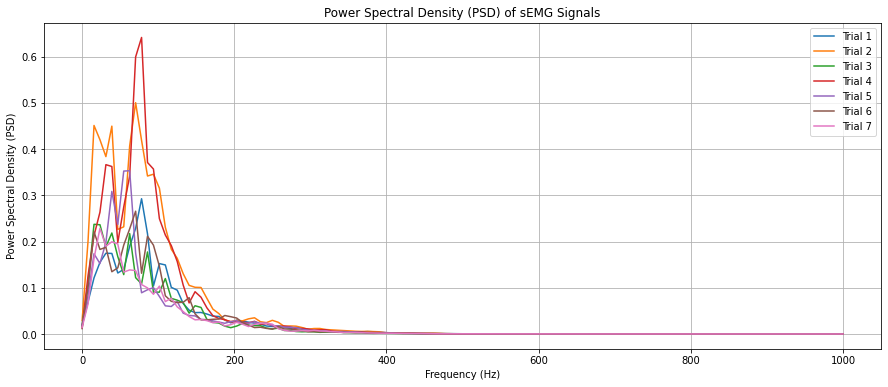

In [5]:
# Define the sampling frequency (Hz) and number of trials of the sEMG data
sampling_frequency = 2000
num_trials = 7

# Function to compute and plot the PSD
def compute_and_plot_PSD(sEMG_data, sampling_frequency):

    plt.figure(figsize=(15, 6))  # Set the size of the plot (width, height)
    
    for trial_idx in range(num_trials):
        f2, Pxx2 = signal.welch(sEMG_data[trial_idx], fs=sampling_frequency)
        plt.plot(f2, Pxx2, label=f'Trial {trial_idx+1}')

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (PSD)')
    plt.title('Power Spectral Density (PSD) of sEMG Signals')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to compute and plot the PSD
compute_and_plot_PSD(semg_1_list[:7], sampling_frequency)


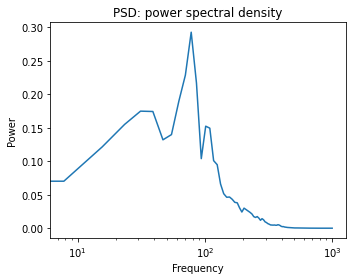

In [6]:
def plot_psd(data, fs):

    # Compute the PSD
    freqs, psd = signal.welch(data, fs)
    
    # Plot the PSD
    plt.figure(figsize=(5, 4))
    plt.semilogx(freqs, psd)
    plt.title('PSD: power spectral density')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.tight_layout()
    plt.show()

plot_psd(semg_1_list[0], 2000)


In [8]:
print("sub1_semg_1_list: ", len(semg_1_list[0]))

sub1_semg_1_list:  16000


**Applying Butterworth Filter to the sEMG data to keep samples only between 20Hz and 500Hz.**

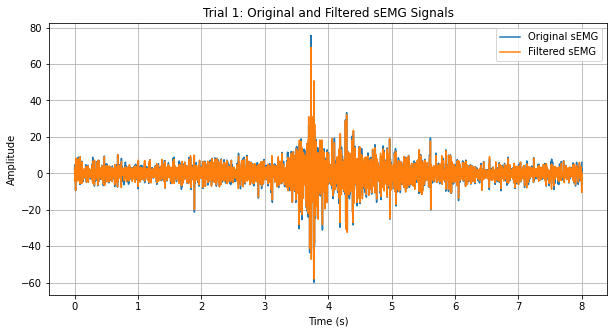

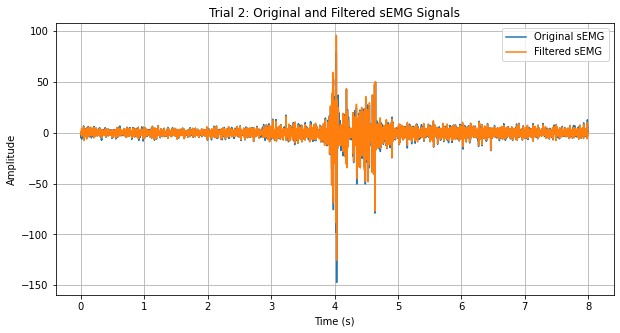

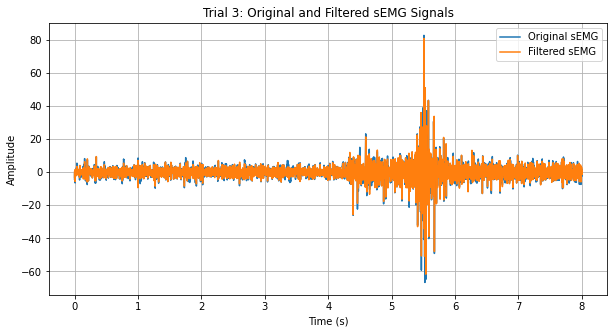

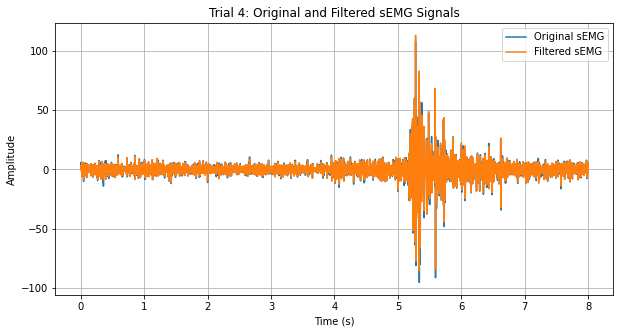

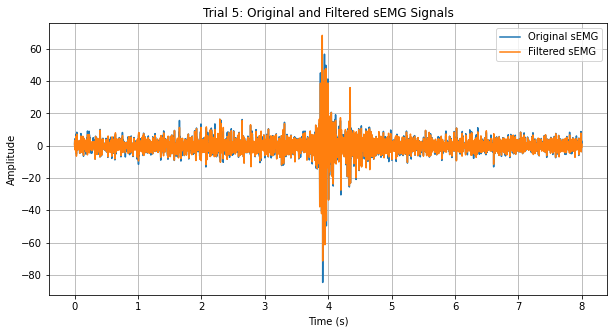

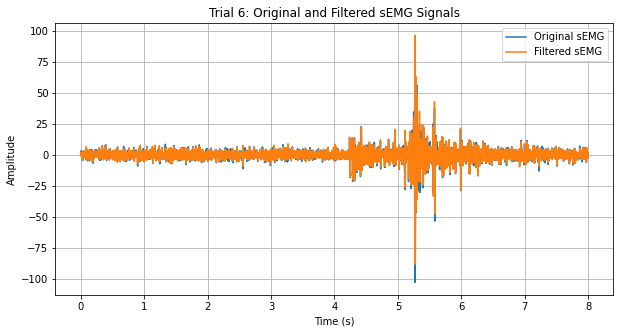

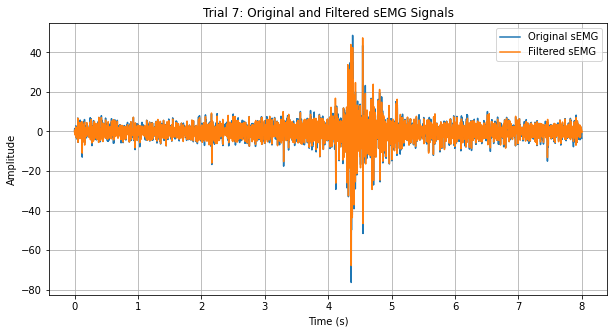

In [9]:
# Define the desired frequency range for the butterworth filter
low_freq = 20  # Lower cutoff frequency in Hz
high_freq = 500  # Higher cutoff frequency in Hz

# Sample sEMG data (1D array) with 16000 samples per trial and 10 trials
num_trials = 7
num_samples_per_trial = 16000

# Function to apply a bandpass filter to the sEMG data
def apply_bandpass_filter(sEMG_data, low_freq, high_freq, sampling_frequency):
    # Compute the digital filter coefficients
    nyquist_freq = 0.5 * sampling_frequency
    low_normalized_freq = low_freq / nyquist_freq
    high_normalized_freq = high_freq / nyquist_freq
    b, a = signal.butter(4, [low_normalized_freq, high_normalized_freq], btype='band')

    # Apply the filter to each trial of the sEMG data
    filtered_data = np.zeros_like(sEMG_data)
    for trial_idx in range(num_trials):
        filtered_data[trial_idx] = signal.filtfilt(b, a, sEMG_data[trial_idx])

    detrended_signal = detrend(filtered_data)

    return detrended_signal

# Apply the bandpass filter to the sEMG data
filtered_data = apply_bandpass_filter(semg_1_list, low_freq, high_freq, sampling_frequency)

# Plot the original and filtered sEMG signals for one trial
trial_idx = 0
time = np.arange(num_samples_per_trial) / sampling_frequency

for trial_idx in range(num_trials):
    plt.figure(figsize=(10, 5))
    plt.plot(time, semg_1_list[trial_idx], label='Original sEMG')
    plt.plot(time, filtered_data[trial_idx], label='Filtered sEMG')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Trial {trial_idx+1}: Original and Filtered sEMG Signals')
    plt.legend()
    plt.grid(True)
    plt.show()


**Applied the bandpass filter logic using spark UDF to each row.**

In [15]:
butterworth_filter = F.udf(lambda row: apply_butterworth_filter(row), T.ArrayType(T.DoubleType()))

def apply_butterworth_filter(sEMG_data, low_freq=20, high_freq=500, sampling_frequency=2000):
    # Compute the digital filter coefficients

#     print("sEMG_data: ", sEMG_data)
    nyquist_freq = 0.5 * sampling_frequency
    low_normalized_freq = low_freq / nyquist_freq
    high_normalized_freq = high_freq / nyquist_freq
    b, a = signal.butter(4, [low_normalized_freq, high_normalized_freq], btype='band')

    # Apply the filter to each trial of the sEMG data
    filtered_data = np.zeros_like(sEMG_data)
    filtered_data = signal.filtfilt(b, a, sEMG_data)

    return filtered_data.tolist()


filtered_grouped_semg_df = grouped_semg_df.withColumn('filtered_semg_1_list', butterworth_filter(grouped_semg_df['semg_1_list']))
filtered_grouped_semg_df = filtered_grouped_semg_df.withColumn('filtered_semg_2_list', butterworth_filter(filtered_grouped_semg_df['semg_2_list']))
filtered_grouped_semg_df = filtered_grouped_semg_df.withColumn('filtered_semg_3_list', butterworth_filter(filtered_grouped_semg_df['semg_3_list']))
filtered_grouped_semg_df = filtered_grouped_semg_df.withColumn('filtered_semg_4_list', butterworth_filter(filtered_grouped_semg_df['semg_4_list']))
filtered_grouped_semg_df = filtered_grouped_semg_df.withColumn('filtered_semg_5_list', butterworth_filter(filtered_grouped_semg_df['semg_5_list']))

filtered_grouped_semg_df.show()


+----------+--------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|subject_id|activity|trial_index|         semg_1_list|         semg_2_list|         semg_3_list|         semg_4_list|         semg_5_list|filtered_semg_1_list|filtered_semg_2_list|filtered_semg_3_list|filtered_semg_4_list|filtered_semg_5_list|
+----------+--------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         1|     1.0|        9.0|[2.37726334323424...|[4.92166561376537...|[1.82641363360929...|[-2.9651598901044...|[-12.653127245297...|[0.07375521307044...|[0.12542378728474...|[-0.3517062174136...|[0.19636289082462...|[0.00479762497564...|
|         1|     1.0|   

In [16]:
# UDF for linear detrending
def linear_detrend(signal):
    detrended_signal = detrend(signal)
    return detrended_signal.tolist()

# Register the UDF
linear_detrend_udf = F.udf(linear_detrend, T.ArrayType(T.FloatType()))

# Apply the UDF to the DataFrame
filtered_grouped_semg_df = filtered_grouped_semg_df.withColumn("filtered_semg_1_list", linear_detrend_udf(filtered_grouped_semg_df["filtered_semg_1_list"]))
filtered_grouped_semg_df = filtered_grouped_semg_df.withColumn("filtered_semg_2_list", linear_detrend_udf(filtered_grouped_semg_df["filtered_semg_2_list"]))
filtered_grouped_semg_df = filtered_grouped_semg_df.withColumn("filtered_semg_3_list", linear_detrend_udf(filtered_grouped_semg_df["filtered_semg_3_list"]))
filtered_grouped_semg_df = filtered_grouped_semg_df.withColumn("filtered_semg_4_list", linear_detrend_udf(filtered_grouped_semg_df["filtered_semg_4_list"]))
filtered_grouped_semg_df = filtered_grouped_semg_df.withColumn("filtered_semg_5_list", linear_detrend_udf(filtered_grouped_semg_df["filtered_semg_5_list"]))


**Verifying if the filtering worked using spark UDF.**

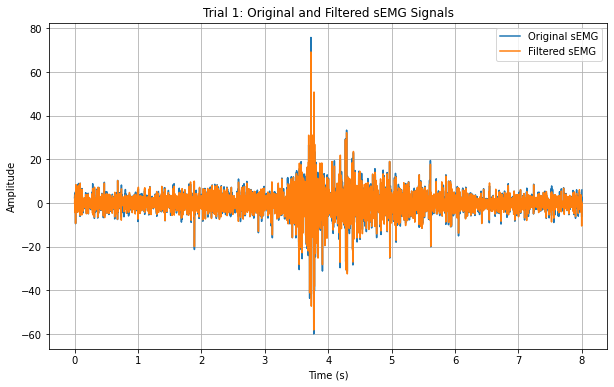

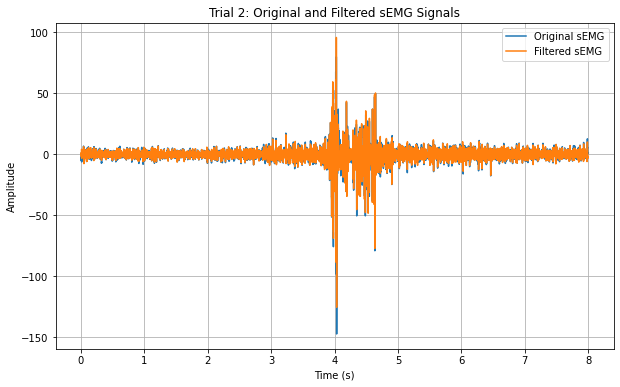

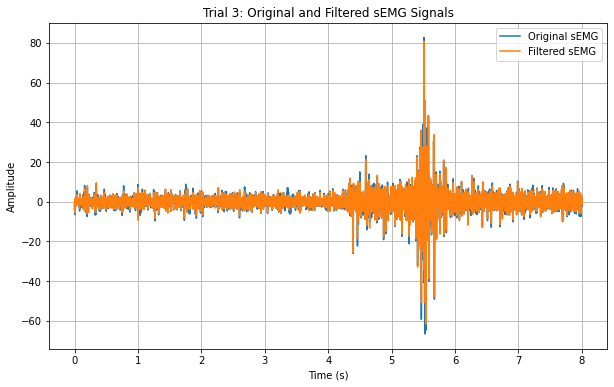

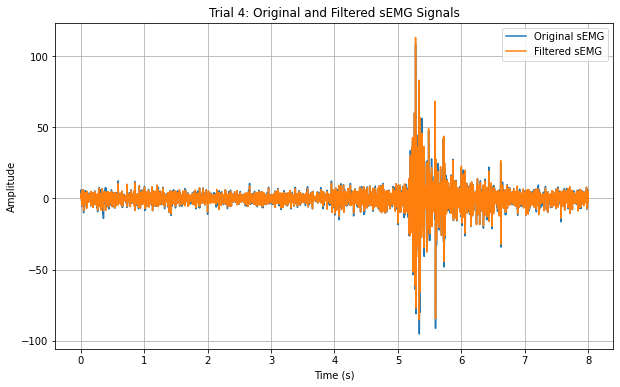

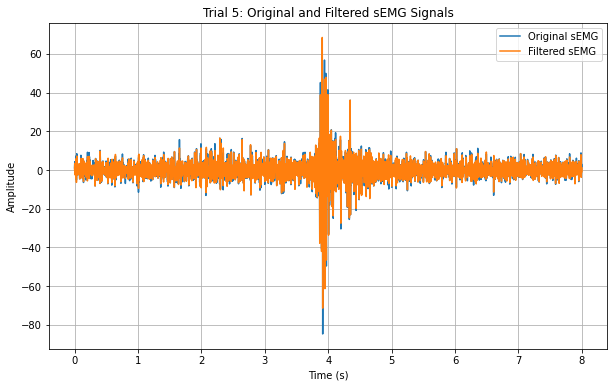

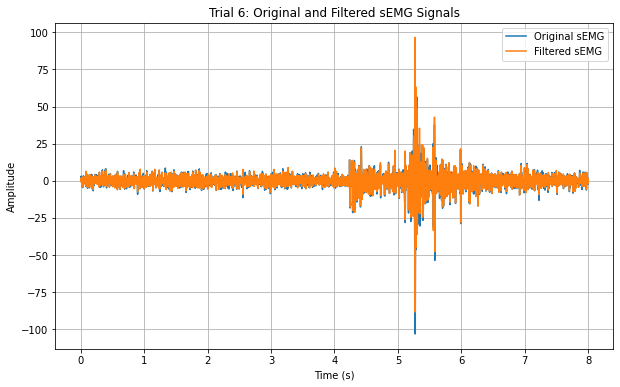

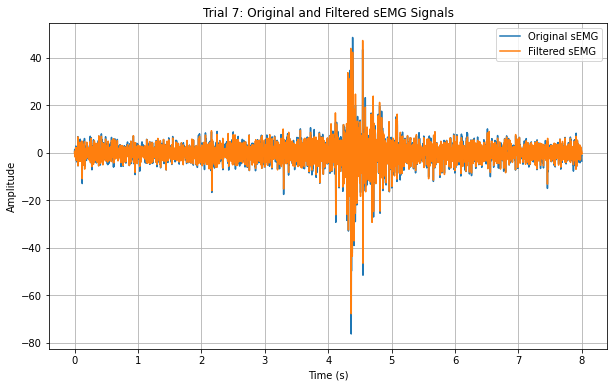

In [17]:
semg_1_list = [row['semg_1_list'] for row in filtered_grouped_semg_df.collect()]
filtered_semg_1_list = [row['filtered_semg_1_list'] for row in filtered_grouped_semg_df.collect()]

for trial_idx in range(7):
    plt.figure(figsize=(10, 5))
    plt.plot(time, semg_1_list[trial_idx], label='Original sEMG')
    plt.plot(time, filtered_semg_1_list[trial_idx], label='Filtered sEMG')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Trial {trial_idx+1}: Original and Filtered sEMG Signals')
    plt.legend()
    plt.grid(True)
    plt.show()

**Write the data as output to parquet files.**

In [12]:
# Get the start time
st = time.time()

#Writing to DB:
print("Repartitioning and writing as parquet..")
filtered_grouped_semg_df = filtered_grouped_semg_df.repartition(21, 'activity')
filtered_grouped_semg_df.write.mode('overwrite').parquet("denoised_grouped_semg_stage/")
print("Completed repartitioning and writing.")

# Get the end time
et = time.time()

# Calculate the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Repartitioning and writing as parquet..


Completed repartitioning and writing.
Execution time: 227.4251320362091 seconds
